In [1]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os.path as op
import json
from pathlib import Path
import shutil
import logging
from tqdm import tqdm
from skimage import io
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#print(os.getcwd())
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17


data_head_dir = Path('/Users/sk_sunflower163.com/Desktop/data')
# The path may be: ../data

subdirs = [subdir for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]


In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('/Users/sk_sunflower163.com/Desktop/train_source_images.txt')
validate_ids = load_text_ids('/Users/sk_sunflower163.com/Desktop/val_source_images.txt')
test_ids = load_text_ids('/Users/sk_sunflower163.com/Desktop/test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

# Loading and pre processing the data

In [4]:
import random
import tensorflow as tf
from PIL import Image 

def load_and_preprocess(img_loc, label):
    def _inner_function(img_loc, label):
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        
        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')
        
        # Convert PIL image to numpy array and resize
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])
        
        # Normalize the image to the [0, 1] range
        img = img / 255.0

        # Convert label to integer (assuming binary classification)
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        
        return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    
    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([])  # Scalar label
    
    return X, y


def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 8

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

2023-12-11 13:01:28.334952: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-11 13:01:28.334980: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-11 13:01:28.334988: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-11 13:01:28.335163: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-11 13:01:28.335326: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# print data set
print("Training Dataset Samples:")
for img, label in tf_dataset_train.take(5):
    print("Image shape:", img.shape, "Label:", label.numpy())
    
print("\nValidation Dataset Samples:")
for img, label in tf_dataset_val.take(5):
    print("Image shape:", img.shape, "Label:", label.numpy())

print("\nTesting Dataset Samples:")
for img, label in tf_dataset_test.take(5):
    print("Image shape:", img.shape, "Label:", label.numpy())


Training Dataset Samples:


2023-12-11 13:01:28.580912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [29679]
	 [[{{node Placeholder/_1}}]]
2023-12-11 13:01:28.581262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [29679]
	 [[{{node Placeholder/_0}}]]
2023-12-11 13:01:28.605168: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Image shape: (8, 299, 299, 3) Label: [1 1 0 1 1 0 1 1]
Image shape: (8, 299, 299, 3) Label: [1 1 1 1 1 1 0 0]
Image shape: (8, 299, 299, 3) Label: [0 1 1 1 0 1 0 0]
Image shape: (8, 299, 299, 3) Label: [1 0 0 1 1 1 1 1]
Image shape: (8, 299, 299, 3) Label: [0 1 1 0 0 1 0 0]

Validation Dataset Samples:
Image shape: (8, 299, 299, 3) Label: [0 0 0 0 0 0 0 1]
Image shape: (8, 299, 299, 3) Label: [0 1 0 1 0 0 0 0]


2023-12-11 13:01:29.011324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [11286]
	 [[{{node Placeholder/_1}}]]
2023-12-11 13:01:29.011462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [11286]
	 [[{{node Placeholder/_0}}]]
2023-12-11 13:01:29.194885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [12

Image shape: (8, 299, 299, 3) Label: [1 0 0 1 1 1 1 1]
Image shape: (8, 299, 299, 3) Label: [0 0 0 0 0 1 0 0]
Image shape: (8, 299, 299, 3) Label: [0 1 0 1 0 0 0 1]

Testing Dataset Samples:
Image shape: (8, 299, 299, 3) Label: [1 1 1 1 0 0 1 1]
Image shape: (8, 299, 299, 3) Label: [1 1 1 1 1 0 0 0]
Image shape: (8, 299, 299, 3) Label: [1 1 1 1 1 1 0 1]
Image shape: (8, 299, 299, 3) Label: [1 1 1 1 1 1 0 1]
Image shape: (8, 299, 299, 3) Label: [0 0 1 0 1 1 1 0]


# Train CNN +  MLP

### (a)

### ii - iii

00:30:44 | WARNING | optimizer       | At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
00:30:44 | WARNING | __init__        | There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.


Epoch 1/20
3710/3710 [==============================] - 1284s 346ms/step - loss: 0.5159 - accuracy: 0.7301 - val_loss: 0.6992 - val_accuracy: 0.6805
Epoch 2/20
3710/3710 [==============================] - 948s 255ms/step - loss: 0.2982 - accuracy: 0.8664 - val_loss: 0.6005 - val_accuracy: 0.7782
Epoch 3/20
3710/3710 [==============================] - 760s 205ms/step - loss: 0.1683 - accuracy: 0.9332 - val_loss: 0.7659 - val_accuracy: 0.7341
Epoch 4/20
3710/3710 [==============================] - 751s 202ms/step - loss: 0.1184 - accuracy: 0.9543 - val_loss: 2.1381 - val_accuracy: 0.6544
Epoch 5/20
3710/3710 [==============================] - 732s 197ms/step - loss: 0.0926 - accuracy: 0.9660 - val_loss: 0.6415 - val_accuracy: 0.8059
Epoch 6/20
3710/3710 [==============================] - 736s 198ms/step - loss: 0.0721 - accuracy: 0.9731 - val_loss: 0.5961 - val_accuracy: 0.8571
Epoch 7/20
3710/3710 [==============================] - 742s 200ms/step - loss: 0.0633 - accuracy: 0.9765 - val

2023-12-12 04:03:25.105416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [12823]
	 [[{{node Placeholder/_1}}]]
2023-12-12 04:03:25.105681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [12823]
	 [[{{node Placeholder/_0}}]]


              precision    recall  f1-score   support

           0       0.35      0.37      0.36      4418
           1       0.66      0.64      0.65      8405

    accuracy                           0.55     12823
   macro avg       0.51      0.51      0.51     12823
weighted avg       0.55      0.55      0.55     12823



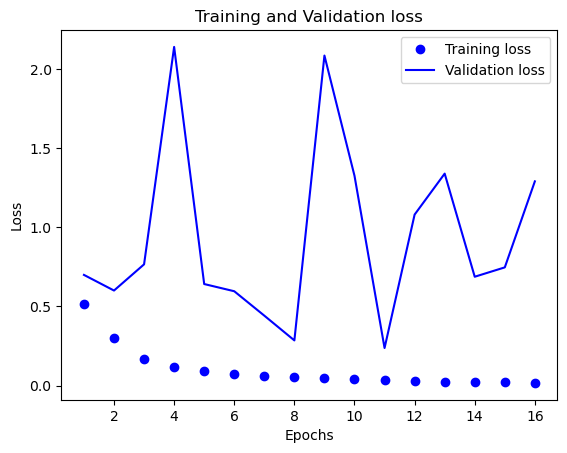

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


IMAGE_SIZE = (299, 299)
#custom_learningRate = 0.00001
model = Sequential([
    # Convolutional layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flattening the output for the MLP
    Flatten(),

    # MLP layers
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

model.compile(
    Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy'],
    run_eagerly=True
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Training
history = model.fit(
    tf_dataset_train,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping, checkpoint]
)

# Load the best model saved by ModelCheckpoint
model.load_weights('best_model.h5')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print(f"Test loss: {test_loss}")
print(f'Test accuracy: {test_accuracy}')

# Make predictions
predictions = model.predict(tf_dataset_test)
binary_predictions = (predictions > 0.5).astype(int)
flat_predictions = predictions.flatten()
flat_true_labels = np.concatenate([y.numpy().flatten() for x, y in tf_dataset_test.unbatch()])

# Import classification metrics from scikit-learn
from sklearn.metrics import classification_report, confusion_matrix

# Calculate the classification report
report = classification_report(flat_true_labels, flat_predictions > 0.5)
print(report)

import matplotlib.pyplot as plt


train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)


plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



### (D)

2023-12-11 15:31:37.957478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [29679]
	 [[{{node Placeholder/_1}}]]
2023-12-11 15:31:37.957635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [29679]
	 [[{{node Placeholder/_1}}]]


(8, 299, 299, 3) (8,)
Training model: EfficientNetB0


15:31:45 | WARNING | optimizer       | At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
15:31:45 | WARNING | __init__        | There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.


Epoch 1/10


2023-12-11 15:31:48.025311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3710/3710 [==============================] - ETA: 0s - loss: 0.6748 - accuracy: 0.5811

2023-12-11 15:39:01.188029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3710/3710 [==============================] - 606s 159ms/step - loss: 0.6748 - accuracy: 0.5811 - val_loss: 0.9224 - val_accuracy: 0.3218
Epoch 2/10
3710/3710 [==============================] - 1070s 288ms/step - loss: 0.6619 - accuracy: 0.5958 - val_loss: 0.6341 - val_accuracy: 0.7010
Epoch 3/10
3710/3710 [==============================] - 887s 239ms/step - loss: 0.6615 - accuracy: 0.5893 - val_loss: 0.5658 - val_accuracy: 0.6885
Epoch 4/10
3710/3710 [==============================] - 958s 258ms/step - loss: 0.6581 - accuracy: 0.5963 - val_loss: 0.7447 - val_accuracy: 0.6782
Epoch 5/10
3710/3710 [==============================] - 1498s 404ms/step - loss: 0.6606 - accuracy: 0.5920 - val_loss: 0.7539 - val_accuracy: 0.6782
Epoch 6/10
3710/3710 [==============================] - 636s 171ms/step - loss: 0.6594 - accuracy: 0.5964 - val_loss: 1.4364 - val_accuracy: 0.6782
Epoch 7/10
3710/3710 [==============================] - 560s 151ms/step - loss: 0.6598 - accuracy: 0.5910 - val_loss: 1.7

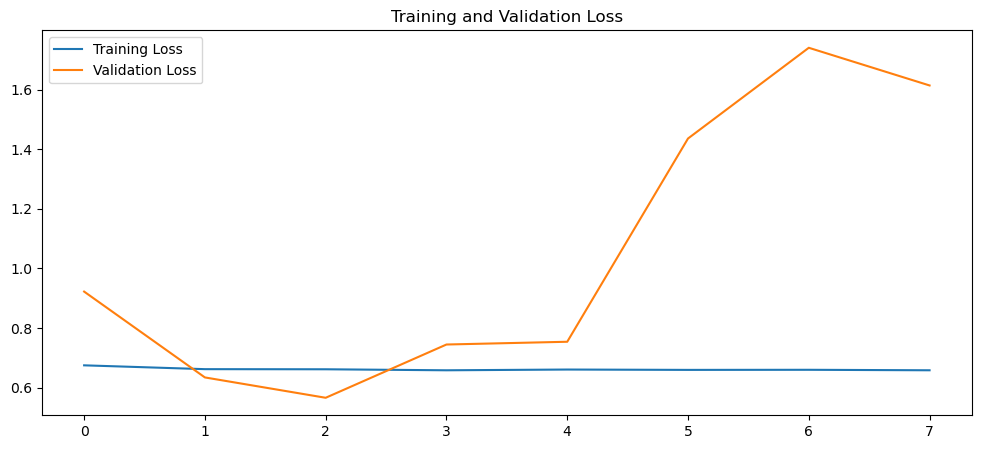

EfficientNetB0 Accuracy: 0.3444591760635376



2023-12-11 17:27:58.044146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1603/1603 [==============================] - 194s 114ms/step


2023-12-11 17:31:11.524108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [12823]
	 [[{{node Placeholder/_1}}]]
2023-12-11 17:31:11.524288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [12823]
	 [[{{node Placeholder/_1}}]]


Classification Report for EfficientNetB0:
               precision    recall  f1-score   support

           0       0.34      1.00      0.51      4418
           1       1.00      0.00      0.00      8405

    accuracy                           0.34     12823
   macro avg       0.67      0.50      0.26     12823
weighted avg       0.77      0.34      0.18     12823

Training model: ResNet50
94765736/94765736 [==============================] - 83s 1us/step


17:33:02 | WARNING | optimizer       | At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
17:33:02 | WARNING | __init__        | There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.


Epoch 1/10


2023-12-11 17:33:03.509926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3710/3710 [==============================] - ETA: 0s - loss: 0.5049 - accuracy: 0.7497

2023-12-11 17:42:30.995842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3710/3710 [==============================] - 777s 207ms/step - loss: 0.5049 - accuracy: 0.7497 - val_loss: 0.5014 - val_accuracy: 0.7583
Epoch 2/10
3710/3710 [==============================] - 734s 198ms/step - loss: 0.4354 - accuracy: 0.7920 - val_loss: 0.5484 - val_accuracy: 0.7252
Epoch 3/10
3710/3710 [==============================] - 798s 215ms/step - loss: 0.4168 - accuracy: 0.8035 - val_loss: 0.5738 - val_accuracy: 0.7173
Epoch 4/10
3710/3710 [==============================] - 785s 212ms/step - loss: 0.4143 - accuracy: 0.8014 - val_loss: 0.5844 - val_accuracy: 0.7096
Epoch 5/10
3710/3710 [==============================] - 753s 203ms/step - loss: 0.4038 - accuracy: 0.8110 - val_loss: 0.5863 - val_accuracy: 0.7105
Epoch 6/10
1603/1603 [==============================] - 239s 149ms/step - loss: 0.3837 - accuracy: 0.8677
Test loss: 0.3836848735809326
Test accuracy: 0.8676596879959106


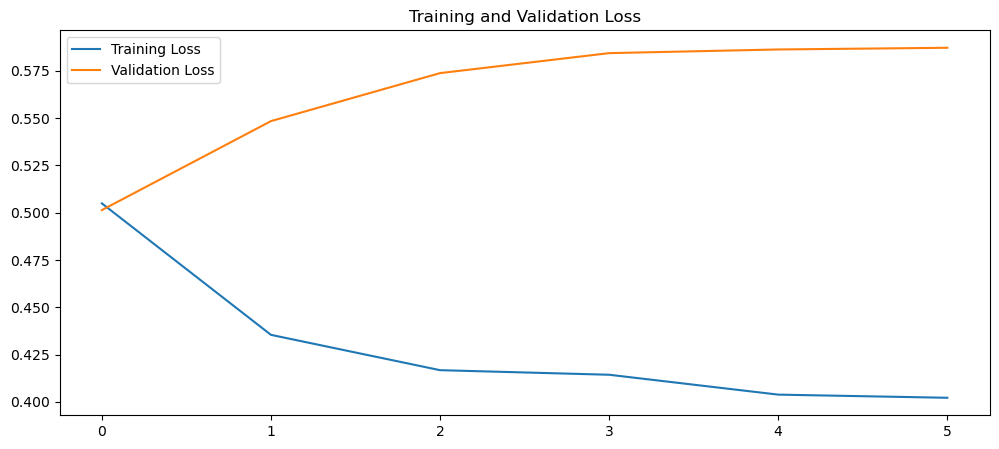

ResNet50 Accuracy: 0.8676596879959106



2023-12-11 18:53:44.010567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1603/1603 [==============================] - 246s 150ms/step


2023-12-11 18:57:49.947011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [12823]
	 [[{{node Placeholder/_1}}]]
2023-12-11 18:57:49.947139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [12823]
	 [[{{node Placeholder/_0}}]]


Classification Report for ResNet50:
               precision    recall  f1-score   support

           0       0.35      0.37      0.36      4418
           1       0.66      0.64      0.65      8405

    accuracy                           0.55     12823
   macro avg       0.50      0.50      0.50     12823
weighted avg       0.55      0.55      0.55     12823

Training model: VGG16
58889256/58889256 [==============================] - 50s 1us/step


18:59:02 | WARNING | optimizer       | At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
18:59:02 | WARNING | __init__        | There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.


Epoch 1/10


2023-12-11 18:59:03.299663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3710/3710 [==============================] - ETA: 0s - loss: 0.5893 - accuracy: 0.7147

2023-12-11 19:11:19.952961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3710/3710 [==============================] - 1016s 272ms/step - loss: 0.5893 - accuracy: 0.7147 - val_loss: 0.6820 - val_accuracy: 0.7227
Epoch 2/10
3710/3710 [==============================] - 3035s 818ms/step - loss: 0.4207 - accuracy: 0.8114 - val_loss: 0.6947 - val_accuracy: 0.7363
Epoch 3/10
3710/3710 [==============================] - 3920s 1s/step - loss: 0.3810 - accuracy: 0.8273 - val_loss: 0.7052 - val_accuracy: 0.7281
Epoch 4/10
3710/3710 [==============================] - 2061s 556ms/step - loss: 0.3495 - accuracy: 0.8488 - val_loss: 0.6906 - val_accuracy: 0.7388
Epoch 5/10
3710/3710 [==============================] - 1011s 272ms/step - loss: 0.3399 - accuracy: 0.8541 - val_loss: 0.6667 - val_accuracy: 0.7430
Epoch 6/10
3710/3710 [==============================] - 1016s 274ms/step - loss: 0.3267 - accuracy: 0.8591 - val_loss: 0.6826 - val_accuracy: 0.7395
Epoch 7/10
3710/3710 [==============================] - 2782s 750ms/step - loss: 0.3217 - accuracy: 0.8601 - val_loss: 0

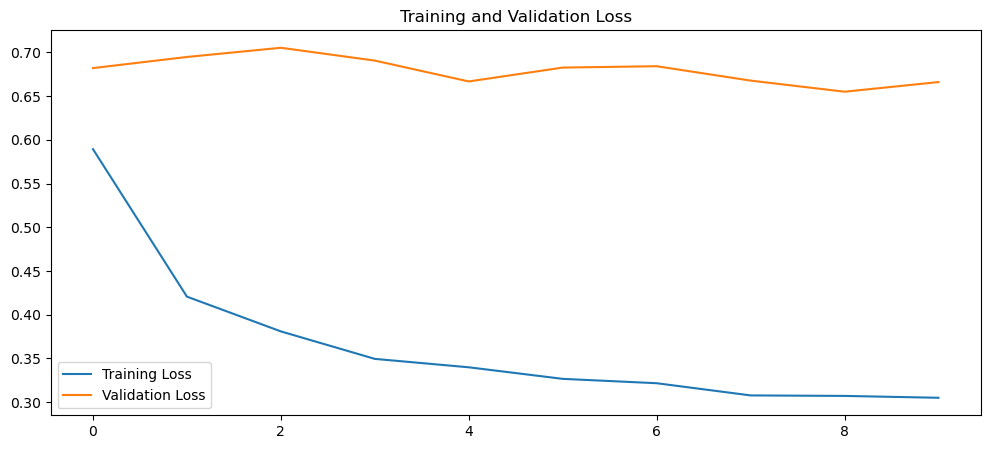

VGG16 Accuracy: 0.9029868245124817



2023-12-12 00:18:38.422777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1603/1603 [==============================] - 393s 244ms/step


2023-12-12 00:25:11.667729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [12823]
	 [[{{node Placeholder/_0}}]]
2023-12-12 00:25:11.667930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [12823]
	 [[{{node Placeholder/_0}}]]


Classification Report for VGG16:
               precision    recall  f1-score   support

           0       0.35      0.39      0.37      4418
           1       0.66      0.62      0.64      8405

    accuracy                           0.54     12823
   macro avg       0.50      0.50      0.50     12823
weighted avg       0.55      0.54      0.54     12823



In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report


for images, labels in tf_dataset_train.take(1):
    print(images.shape, labels.shape)


base_models = {
    "EfficientNetB0": EfficientNetB0,
    "ResNet50": ResNet50,
    "VGG16": VGG16
}


def create_compile_model(base_model_class):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    predictions = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.00001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def train_evaluate_model(model, epochs=10):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(tf_dataset_train,
                        epochs=epochs,
                        validation_data=tf_dataset_val,
                        callbacks=[early_stopping])

    test_loss, test_accuracy = model.evaluate(tf_dataset_test)
    print(f"Test loss: {test_loss}")
    print(f'Test accuracy: {test_accuracy}')


    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    return test_accuracy


for model_name, base_model_class in base_models.items():
    print(f"Training model: {model_name}")
    model = create_compile_model(base_model_class)
    accuracy = train_evaluate_model(model)
    print(f"{model_name} Accuracy: {accuracy}\n")
    

    predictions = model.predict(tf_dataset_test)
    predicted_classes = np.argmax(predictions, axis=1)

    flat_true_labels = np.concatenate([y.numpy().flatten() for x, y in tf_dataset_test.unbatch()])

    report = classification_report(flat_true_labels, predicted_classes)
    print(f"Classification Report for {model_name}:\n", report)



## Conclusion:

The graph shows CNN model with volatile validation loss, indicating potential overfitting. For EfficientNetB0, reveals a sharp increase in validation loss after initial epochs, suggesting overfitting. ResNet50's graph depicts a gradual divergence between training and validation loss, hinting at the beginning of overfitting. Lastly, the VGG16 graph demonstrates the best stability, with training and validation losses leveling off, indicating a relativley better model.

From the classification reports provided for the four models, it's evident that each model has varying performance metrics. The first CNN model shows a balance between precision and recall for class 1 but has a lower performance for class 0. The EfficientNetB0 model has a high precision for class 1 but a recall of 0, indicating it fails to identify any true positives for class 0. This is a sign of a model that is biased towards the majority class. ResNet50 shows a balanced performance similar to the first CNN, but with a slightly lower F1-score for class 1. Lastly, VGG16 has a marginal improvement in recall for class 0 over the first CNN model, but overall similar performance metrics.

In summary, all models have challenges with class 0, with EfficientNetB0 particularly struggling. This could suggest class imbalance or features in class 0 that are not being captured well by the models. The VGG16 and the first CNN model are more balanced in their performance across both classes, but there's a noticeable trade-off between precision and recall, especially for class 0.

